# Bollinger Band Stategy with Exit

In [206]:
# Data manipulation packages
import numpy as np
import pandas as pd

# Financial packages
import talib as ta
import yfinance as yf
import pyfolio as pf

# Graphing packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import datetime
from datetime import date

from talib import MA_Type

## Import dataset

In [207]:
data = yf.download('MSFT')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...
2022-07-26,259.859985,259.880005,249.570007,251.899994,251.899994,39348000
2022-07-27,261.160004,270.049988,258.850006,268.739990,268.739990,45994000
2022-07-28,269.750000,277.839996,267.869995,276.410004,276.410004,33459300


## Compute Indicators

In [208]:
# Defining parameters
window = 30
sd = 1

In [209]:
# Computing moving average and standard deviation
data['moving_average'] = data['Adj Close'].rolling(window=window, center=False).mean()
data['std_dev'] = data['Adj Close'].rolling(window=window, center=False).std()

In [210]:
# Computing upper and lower bands
data['upper_band'] = data['moving_average'] + sd * data['std_dev']
data['lower_band'] = data['moving_average'] - sd * data['std_dev']

## Compute Signals

In [186]:
# Computing signals
data['long_entry'] = data['Adj Close'] < data.lower_band   
data['long_exit'] = data['Adj Close'] >= data.moving_average

data['positions_long'] = np.nan  
data.loc[data.long_entry, 'positions_long'] = 1  
data.loc[data.long_exit, 'positions_long'] = 0 

data.positions_long = data.positions_long.fillna(method='ffill')

data['short_entry'] = data['Adj Close'] > data.upper_band   
data['short_exit'] = data['Adj Close'] <= data.moving_average

data['positions_short'] = np.nan  
data.loc[data.short_entry, 'positions_short'] = -1  
data.loc[data.short_exit, 'positions_short'] = 0  

data.positions_short = data.positions_short.fillna(method='ffill')  

data['positions'] = data.positions_long + data.positions_short

print(data['positions'].value_counts())
print(data['positions'].isnull().sum())

-1.0    4745
 1.0    2678
 0.0    1718
Name: positions, dtype: int64
29


In [201]:
# data['signal'] = np.where(data['Adj Close']>data['upper_band'],-1,0)
# data['signal'] = np.where(data['Adj Close']<data['lower_band'],1,data['signal'])
# data['positions'] = data['signal']

# print(data['positions'].value_counts())
# print(data['positions'].isnull().sum())

 0    4049
-1    3354
 1    1739
Name: positions, dtype: int64
0


## Strategy Performance Analysis

In [202]:
# Calculate log returns
data['returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.dropna(inplace=True)

# Calculate strategy returns
data['strategy_returns'] = data['returns'] * data['positions'].shift(1)


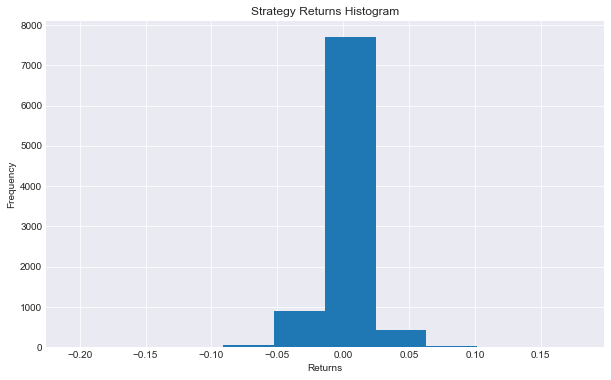

In [203]:
# Plot histogram
plt.figure(figsize=(10, 6))
data.strategy_returns.hist()
plt.title('Strategy Returns Histogram')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

In [204]:
# Calculate sharpe ratio
daily_sharpe_ratio = (data['strategy_returns'].mean()) / data['strategy_returns'].std()
sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
sharpe_ratio

-0.030225053233550514

Start date,1986-04-25
End date,2022-08-01
Total months,435
,Backtest
Annual return,-4.0%
Cumulative returns,-77.5%
Annual volatility,25.8%
Sharpe ratio,-0.03
Calmar ratio,-0.04
Stability,0.25
Max drawdown,-92.8%


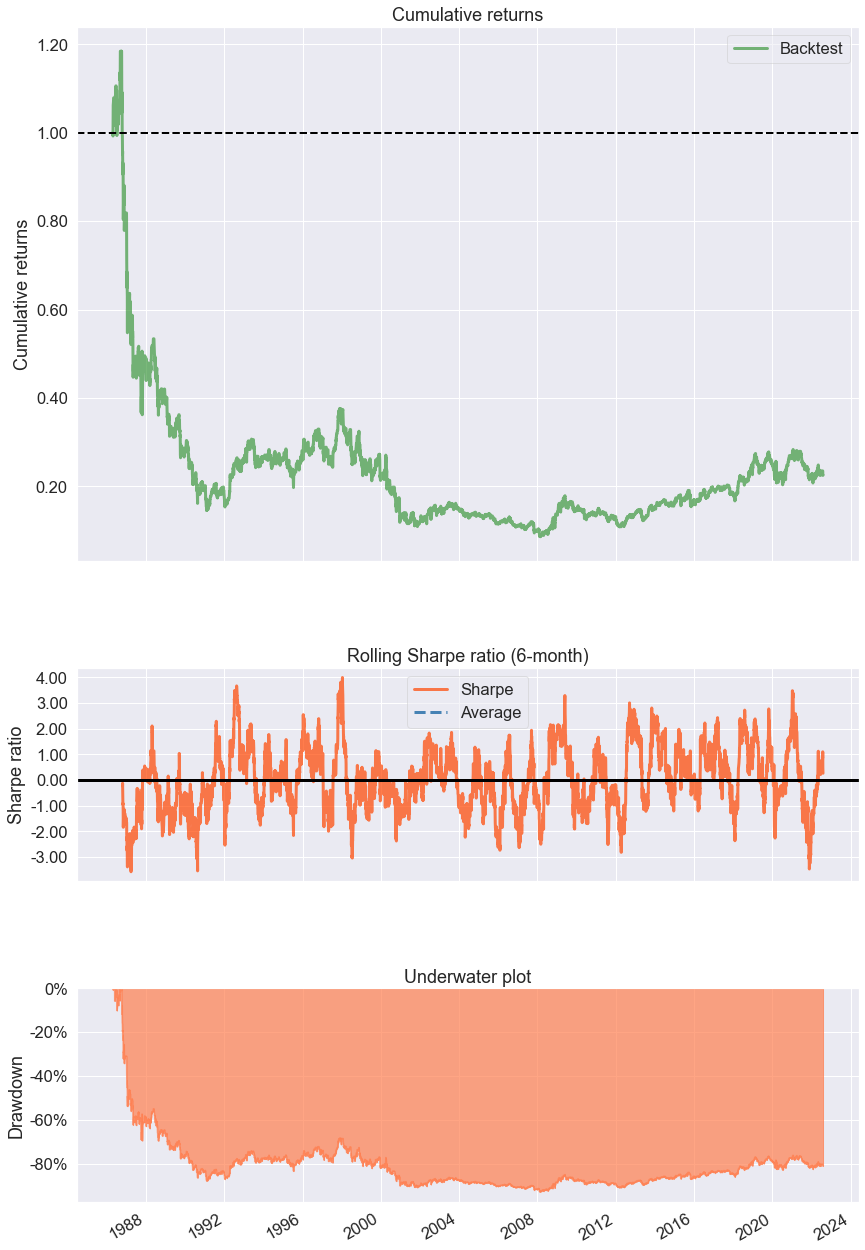

In [205]:
pf.create_simple_tear_sheet(data.strategy_returns)